**Mounting Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
#Uncomment if you want to use Dataset prepared by the authors of the paper Character-level Convolutional Networks for Text
#Classification

DIR = '/content/drive/My Drive/AG_News/'

#Uncomment if you want to use Dataset prepared by us
# Make sure you've executed Cleaning.ipynb first

# DIR = '/content/drive/My Drive/OurDataset/'

**Load in and Visualise the dataset**

---



In [0]:
import pandas as pd
train_data_source = DIR + "train.csv"
test_data_source =  DIR + "test.csv"

train_df = pd.read_csv(train_data_source, header=None)
test_df = pd.read_csv(test_data_source, header=None)
train_df.head()

,0,1,2
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


**Data Preprocessing**

---


Converting characters to vectors (Merge columns)




In [0]:
import numpy as np
import sys
import csv
from torch.utils.data import Dataset
';//'
class MyDataset(Dataset):
    def __init__(self, data_path, max_length):
        self.data_path = data_path
        self.vocabulary = list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’’’/\|_@#$%ˆ&*˜‘+-=<>()[]{}")
        self.identity_mat = np.identity(len(self.vocabulary))
        texts, labels = [], []
        with open(data_path) as csv_file:
            reader = csv.reader(csv_file, quotechar='"')
            
            for idx, line in enumerate(reader):
                text = ""
        
                text = line[1]+' '+line[2]
                label = int(line[0])-1 
                texts.append(text.lower()) 
                labels.append(label)
        #print(texts[0])
        cleaned_text=[]
        keeplist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-,;.!?:’’’/\|_@#$%ˆ&*˜‘+-=<>()[]{}')
        for ln in texts:
            cleaned = ''.join(filter(keeplist.__contains__, ln))  
            cleaned = cleaned.lower()
            cleaned_text.append(cleaned)   


        self.texts = cleaned_text
        #print(self.texts[0])
        self.labels = labels
        self.max_length = max_length
        self.length = len(self.labels)
        self.num_classes = len(set(self.labels))

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        raw_text = self.texts[index]
        data = np.array([self.identity_mat[self.vocabulary.index(i)] for i in list(raw_text) if i in self.vocabulary],
                        dtype=np.float32)
        if len(data) > self.max_length:
            data = data[:self.max_length]
        elif 0 < len(data) < self.max_length:
            data = np.concatenate(
                (data, np.zeros((self.max_length - len(data), len(self.vocabulary)), dtype=np.float32)))
        elif len(data) == 0:
            data = np.zeros((self.max_length, len(self.vocabulary)), dtype=np.float32)
        label = self.labels[index]
        return data, label

In [0]:
#Extract data using MyDataset Class
# Data with both columns merged and all lower case letters
import csv
max_length = 1014 #maximum characters in a sentence
train_set = MyDataset(DIR + "train.csv", max_length)     # fix maxlength to 1014
test_set = MyDataset(DIR + "test.csv", max_length)          # fix maxlength to 1014
#train_set.texts

In [0]:
#verifying lengths of  AG News train and test set
print(len(train_set.texts))
print(len(test_set.texts))

120000
7600


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [0]:
#pass parameters for training
train_params = {"batch_size": 128, "shuffle": False, "num_workers": 0}  #Purposely not shuffled to verify the encoding of characters.

#Load Training dataset                 
train_loader = DataLoader(train_set, **train_params)


**Training, Validation, and Test Data**

---



In [0]:
#reset shuffle permissions to True!
dataset = MyDataset( DIR + "train.csv", 1014)
train_set, val_set = torch.utils.data.random_split(dataset, [100000, 20000])
## print out the shapes of your resultant feature data
print("Feature Shapes:")
print("Train set: \t\t{}".format(len(train_set)), 
      "\nValidation set: \t{}".format(len(val_set)),
      "\nTest set: \t\t{}".format(len(test_set)))

Feature Shapes:
Train set: 		100000 
Validation set: 	20000 
Test set: 		7600


In [0]:
#Dataloaders
batch_size = 128
training_params = {"batch_size": batch_size, "shuffle": True,"num_workers": 0} #shuffle deck
test_params = {"batch_size": batch_size,"shuffle": False, "num_workers": 0}

training_generator = DataLoader(train_set, **training_params)
validation_generator = DataLoader(val_set, **training_params)
test_generator = DataLoader(test_set, **test_params)

In [0]:
# Check availability of GPU
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


**Defining the Network**

---



In [0]:
class CharCNN(nn.Module):
    def __init__(self, n_classes , input_length , input_dim ,
                 n_conv_filters ,
                 n_fc_neurons ):
        super(CharCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, n_conv_filters, kernel_size=7, padding=0)
        self.conv2 = nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=7, padding=0)
        self.conv3 = nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0)
        self.conv4 = nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0)
        self.conv5 = nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0)
        self.conv6 = nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0)

        dimension = int(((input_length - 96) / 27) * n_conv_filters) # since the stride used for max_pool is 3 and not 1!!!
        #dimension = 8704
        self.fc1 = nn.Linear(dimension, n_fc_neurons)   
        self.fc2 = nn.Linear(n_fc_neurons, n_fc_neurons)
        self.out = nn.Linear(n_fc_neurons, n_classes)

        if n_conv_filters == 256 and n_fc_neurons == 1024:
            self._create_weights(mean=0.0, std=0.05)
        elif n_conv_filters == 1024 and n_fc_neurons == 2048:
            self._create_weights(mean=0.0, std=0.02)

    def _create_weights(self, mean=0.0, std=0.05):
        for module in self.modules():
            if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
                module.weight.data.normal_(mean, std)
                
       
    
    def forward(self, t):
        #define input layer
        t = t.transpose(1, 2)    #Height = 70, Width = 1014
        
        #define hidden layers

        #convolution layers #1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool1d(t,3)
        
        #2
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool1d(t,3)
       
        #3
        t = self.conv3(t)
        t = F.relu(t)
        
        #4
        t = self.conv4(t)
        t = F.relu(t)

        #5
        t = self.conv5(t)
        t = F.relu(t)
        
        #6
        t = self.conv6(t)
        t = F.relu(t)
        t = F.max_pool1d(t,3)
        #F.max_pool1d

        #Fully_Connected Layers
        t = t.view(t.size(0), -1)
        #t = t.reshape(-1, 8704) #to define the size for fully connected layers

        t = self.fc1(t)
        t = F.dropout(t,0.5)

        t = self.fc2(t)
        t = F.dropout(t,0.5)
       
        t = self.out(t)
        
        #t = F.softmax(t,dim = 1) #check the dimension according to the size!!!
        #not applied softmax because in the input of crossentropy loss function, it automatically takes the softmax of every input!!!
        return t

**Instantiate the model**

---

(Choose between training on Small Features v/s Large Features)


In [0]:
input_length = 1014
n_classes = 4
input_dim = 70
n_conv_filters_small = 256
n_conv_filters_large = 1024
n_fc_neurons_small = 1024
n_fc_neurons_large = 2048

# Uncomment for training on small feature
model = CharCNN(input_length=1014, n_classes= 4,
                              input_dim= 70,
                             n_conv_filters=n_conv_filters_small, n_fc_neurons=n_fc_neurons_small)

# Uncomment for training on large feature
# model = CharCNN(input_length=1014, n_classes= 4,
#                               input_dim= 70,
#                              n_conv_filters=n_conv_filters_large, n_fc_neurons=n_fc_neurons_large)
print(model)
    


CharCNN(
  (conv1): Conv1d(70, 256, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
  (conv3): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (conv5): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (conv6): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=8704, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=4, bias=True)
)


**Training**

---



In [0]:
# loss and optimization functions
criterion = nn.CrossEntropyLoss()
lr = 0.01
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr , momentum)
print("____model parameters____")
print("lr: \t\t{}".format(lr), 
      "\nmomentum rate: \t{}".format(momentum),
     )


____model parameters____
lr: 		0.01 
momentum rate: 	0.9


In [0]:
import numpy as np
from sklearn import metrics

def get_accuracy(y_true, y_pred):
    y_pred = np.argmax(y_pred, -1)
    output = {}
    output['accuracy'] = metrics.accuracy_score(y_true, y_pred)
    return output

**Train and Validate**

---



In [0]:
#def train(num_epochs):
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix

if torch.cuda.is_available():
        model.cuda()

model.train()
num_iter_per_epoch = len(training_generator)
train_loss_plot = []
loss_plot = []
epoch_plot = []     
num_epochs = 15 #after observing validation loss

for epoch in range(num_epochs):
       
    for iter, batch in enumerate(training_generator):
            train_vector, train_label = batch
            

            if torch.cuda.is_available():
                train_vector = train_vector.cuda()
                train_label = train_label.cuda()
            
            optimizer.zero_grad()
            predictions = model(train_vector)
            train_loss = criterion(predictions, train_label)
            train_loss.backward()
            optimizer.step()

    
            train_accuracy = get_accuracy(train_label.cpu().numpy(), predictions.cpu().detach().numpy())
    
    
    #validation to determine optimum number of epochs
    model.eval()
    
    validloss_append = []
    valid_labels = []
    valid_preds = []
      
    #done after every epoch    
    for batch in validation_generator:
            valid_vector, valid_label = batch
            num_sample = len(valid_label)
            
            #shifting to GPU
            if torch.cuda.is_available():
                valid_vector = valid_vector.cuda()
                valid_label = valid_label.cuda()
            
            with torch.no_grad():
                valid_predictions = model(valid_vector)
            valid_loss = criterion(valid_predictions, valid_label)
    
            validloss_append.append(valid_loss * num_sample)
            
            valid_labels.extend(valid_label.clone().cpu())
            valid_preds.append(valid_predictions.clone().cpu())

    valid_loss = sum(validloss_append) / val_set.__len__()
    loss_plot.append(valid_loss)
    epoch_plot.append(epoch)
    train_loss_plot.append(train_loss)

    val_pred = torch.cat(valid_preds, 0)
    val_label = np.array(valid_labels)
    
    
    
    val_accuracy = get_accuracy(val_label, val_pred.numpy())
    
    print("Epoch: {}/{}...Lr: {}...Validation Loss: {}...Validation Accuracy: {}".format(
            epoch + 1,
             num_epochs,
            optimizer.param_groups[0]['lr'],
           valid_loss, val_accuracy,))

   
    if (epoch+1) % 3 == 0 and epoch > 0:
            current_lr = optimizer.state_dict()['param_groups'][0]['lr']
            current_lr /= 2
            for param_group in optimizer.param_groups:
               param_group['lr'] = current_lr
 
       


Epoch: 1/15...Lr: 0.01...Validation Loss: 1.7556443214416504...Validation Accuracy: {'accuracy': 0.32085}
Epoch: 2/15...Lr: 0.01...Validation Loss: 0.8604167699813843...Validation Accuracy: {'accuracy': 0.6249}
Epoch: 3/15...Lr: 0.01...Validation Loss: 0.6154647469520569...Validation Accuracy: {'accuracy': 0.7589}
Epoch: 4/15...Lr: 0.005...Validation Loss: 0.46401047706604004...Validation Accuracy: {'accuracy': 0.8372}
Epoch: 5/15...Lr: 0.005...Validation Loss: 0.3910796642303467...Validation Accuracy: {'accuracy': 0.86575}
Epoch: 6/15...Lr: 0.005...Validation Loss: 0.4418871998786926...Validation Accuracy: {'accuracy': 0.84775}
Epoch: 7/15...Lr: 0.0025...Validation Loss: 0.43327558040618896...Validation Accuracy: {'accuracy': 0.8438}
Epoch: 8/15...Lr: 0.0025...Validation Loss: 0.3878474831581116...Validation Accuracy: {'accuracy': 0.86765}
Epoch: 9/15...Lr: 0.0025...Validation Loss: 0.41862908005714417...Validation Accuracy: {'accuracy': 0.8618}
Epoch: 10/15...Lr: 0.00125...Validation

In [0]:
print(loss_plot)
print(epoch_plot)
print(train_loss_plot)

[tensor(1.7556, device='cuda:0'), tensor(0.8604, device='cuda:0'), tensor(0.6155, device='cuda:0'), tensor(0.4640, device='cuda:0'), tensor(0.3911, device='cuda:0'), tensor(0.4419, device='cuda:0'), tensor(0.4333, device='cuda:0'), tensor(0.3878, device='cuda:0'), tensor(0.4186, device='cuda:0'), tensor(0.4090, device='cuda:0'), tensor(0.4555, device='cuda:0'), tensor(0.4538, device='cuda:0'), tensor(0.4765, device='cuda:0'), tensor(0.5068, device='cuda:0'), tensor(0.5017, device='cuda:0')]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[tensor(1.2205, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.8010, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.5975, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.4275, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.3051, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.3061, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.3236, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0956, device='cuda:0', 

**Validation Loss Graph**

---



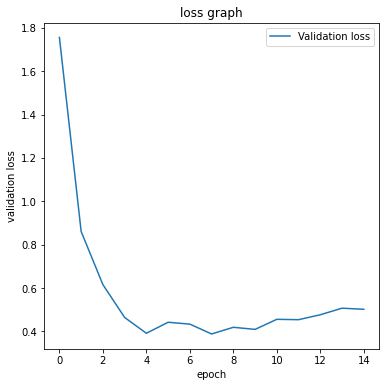

In [0]:
import matplotlib.pyplot as plt

test = plt.figure(figsize=(6,6))
plt.plot(epoch_plot, loss_plot,label='Validation loss')
#plt.plot(epoch_plot, train_loss_plot, label='Training loss')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.title('loss graph')
plt.legend()
test.show()

In [0]:
cm_savepath = '/content/drive/My Drive/NNFL_PROJ/SCREENSHOTS/CharCNN/'
test.savefig(cm_savepath+ 'val loss_15epochs_small.png')

**Testing**

---



In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
model.eval()

test_losses = []
test_labels = []
test_preds = []

for batch in test_generator:
    test_vector, test_label = batch
    num_sample = len(test_label)
    
    if torch.cuda.is_available():
        test_vector = test_vector.cuda()
        test_label = test_label.cuda()
    
    with torch.no_grad():
        test_predictions = model(test_vector)
        
    test_loss = criterion(test_predictions, test_label)
    test_losses.append(test_loss * num_sample)
    
    test_labels.extend(test_label.clone().cpu())
    test_preds.append(test_predictions.clone().cpu())

test_loss = sum(test_losses) / test_set.__len__()
test_pred = torch.cat(test_preds, 0)
test_label = np.array(test_labels)

test_accuracy = get_accuracy(test_label,test_pred.numpy())      

print("Epoch: {}/{}.... Lr: {}.... Loss: {}..... Test Accuracy: {}".format(
            2,
            2,
            optimizer.param_groups[0]['lr'],
            test_loss, test_accuracy))
cm = confusion_matrix(test_label, test_pred.argmax(dim=1))
print("raw form of confusion matrix")
print(cm)


print("Classification Report")
target_names = ['World','Sports','Business','Sci/Tech']
print(classification_report(test_label, test_pred.argmax(dim=1), target_names=target_names))
      


Epoch: 2/2.... Lr: 0.0003125.... Loss: 0.5011541247367859..... Test Accuracy: {'accuracy': 0.8694736842105263}
raw form of confusion matrix
[[1642   94   88   76]
 [  41 1796   28   35]
 [  90   50 1546  214]
 [  57   53  166 1624]]
Classification Report
              precision    recall  f1-score   support

       World       0.90      0.86      0.88      1900
      Sports       0.90      0.95      0.92      1900
    Business       0.85      0.81      0.83      1900
    Sci/Tech       0.83      0.85      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



**Prediction Results**

---



In [0]:
pred = test_pred.argmax(dim=1)
print("Results predicted from model....")
print(pred[0:20])
print("Actual labels....")
print(test_label[0:20])

Results predicted from model....
tensor([2, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0])
Actual labels....
[2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


**Display Confusion Matrix**

---



In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1642   94   88   76]
 [  41 1796   28   35]
 [  90   50 1546  214]
 [  57   53  166 1624]]


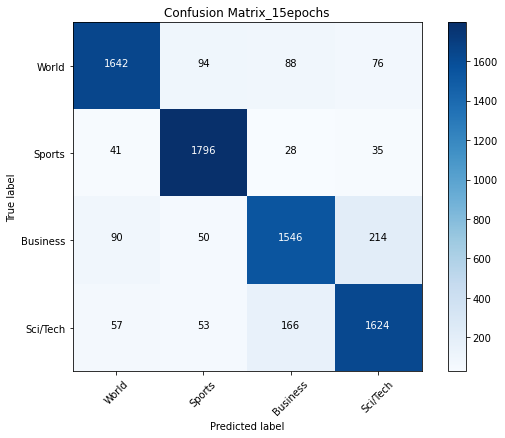

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_set.labels, test_pred.argmax(dim=1))
#print(type(cm))
#cm
names = (
    'World',
'Sports',
'Business',
'Sci/Tech'
)
plt.figure(figsize=(8,6))

Title = 'Confusion Matrix_15epochs'
plot_confusion_matrix(cm, names,title = Title)

cm_savepath = '/content/drive/My Drive/NNFL_PROJ/SCREENSHOTS/CharCNN/'
plt.savefig(cm_savepath+ 'cm_15epochs_author_small.png')

***Predict any random news sample text***

In [0]:
from string import punctuation
def tokenize_single_news(test_news, vocabulary, max_length):
     test_text = ''.join([c for c in test_news if c not in punctuation])  
     identity_mat = np.identity(len(vocabulary))
     data = np.array([identity_mat[vocabulary.index(i)] for i in list(test_text) if i in vocabulary],
                        dtype=np.float32)
     if len(data) > max_length:
            data = data[:max_length]
     elif 0 < len(data) < max_length:
            data = np.concatenate(
                (data, np.zeros((max_length - len(data), len(vocabulary)), dtype=np.float32)))
     elif len(data) == 0:
            data = np.zeros((max_length, len(vocabulary)), dtype=np.float32)
     return data

**Predict Class of Random News Sample**

---



In [0]:
def predict( net , test_news):
    net.eval()
    vocabulary = list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’’’/\|_@#$%ˆ&*˜‘+-=<>()[]{}")
    
    # tokenize news
    max_length = 1014 #max number of characters in a sentence
    features = tokenize_single_news(test_news, vocabulary, max_length)
  
    # convert to tensor to pass into the model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    #check GPU availability
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output = net(feature_tensor.unsqueeze(0))
    
    # convert output to find the maximum index as done by softmax
    te_pred_softmax = F.softmax(output, dim=1)
    pred = te_pred_softmax.argmax(dim=1)

   # pred = output.squeeze() 
    print(pred)
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(pred.item()))
    
    # print the news detected
    if(pred.item()==0):
        print("World news detected!")
    elif(pred.item()==1):
        print("Sports news detected!")
    elif(pred.item()==2):
        print("Business news detected!")
    elif (pred.item()==3):
        print("Sci/Tech news detected!")
    else: 
        print("Cannot detect any news!")    

In [0]:
line =  'LOS ANGELES (Reuters) - A group of technology companies  including Texas Instruments Inc. &lt;TXN.N&gt;, STMicroelectronics  &lt;STM.PA&gt; and Broadcom Corp. &lt;BRCM.O&gt;, on Thursday said they  will propose a new wireless networking standard up to 10 times  the speed of the current generation.'
line = line.lower()

In [0]:
max_length = 1014
vocab = list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’’’/\|_@#$%ˆ&*˜‘+-=<>()[]{}")
result = tokenize_single_news(line,vocab,max_length)
print(result.shape)


(1014, 70)


In [0]:
predict( model, line)

tensor([3], device='cuda:0', grad_fn=<NotImplemented>)
Prediction value, pre-rounding: 3.000000
Sci/Tech news detected!


In [0]:
line = 'The Cleveland Indians pulled within one game of the AL Central lead by beating the Minnesota Twins, 7-1, Saturday night with home runs by Travis Hafner and Victor Martinez.'
line = line.lower()
predict( model, line)

tensor([1], device='cuda:0', grad_fn=<NotImplemented>)
Prediction value, pre-rounding: 1.000000
Sports news detected!


In [0]:
line = 'BEIJING (Reuters) - Beijing on Monday accused a  Chinese-American arrested for spying for Taiwan of building an  espionage network in the United States, and said he could go on  trial very soon.'
line = line.lower()
predict( model, line)

tensor([0], device='cuda:0', grad_fn=<NotImplemented>)
Prediction value, pre-rounding: 0.000000
World news detected!


In [0]:
line = 'HONG KONG (Dow Jones)--China Mobile (Hong Kong) Ltd. (CHL), the listed unit of China #39;s biggest cellular phone operator, posted Wednesday a 7.8 rise in first-half net profit on a 23 increase in its subscriber base. '
line = line.lower()
predict( model, line)

tensor([2], device='cuda:0', grad_fn=<NotImplemented>)
Prediction value, pre-rounding: 2.000000
Business news detected!
